In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def resnet18(num_classes, in_channels=1):
    def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    net.add_module('restnet_block1', resnet_block(64, 64, 2, first_block=True))
    net.add_module('restnet_block2', resnet_block(64, 128, 2))
    net.add_module('restnet_block3', resnet_block(128, 256, 2))
    net.add_module('restnet_block4', resnet_block(256, 512, 2))
    net.add_module('global_avg_pool', nn.AdaptiveAvgPool2d((1, 1)))  # (h, w)
    net.add_module('fc', nn.Sequential(nn.Flatten(), nn.Linear(512, num_classes)))
    return net

In [3]:
net = resnet18(10)
devices = d2l.try_all_gpus()

In [4]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test_acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter), ))
    print(f'测试精度：{animator.Y[0][-1]:.2f}, {timer.avg():.1f}秒/轮, 在{str(devices)}')

KeyboardInterrupt: 

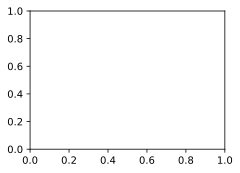

In [5]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

In [ ]:
# train(net, num_gpus=2, batch_size=256 * 2, lr=0.2)